# Ball in Play Model

In [1]:
import pandas as pd
import numpy as np
from configparser import ConfigParser
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


### Utility Functions

In [17]:
def player_id(df, player_lookup, pitching, hitting):

    # create player lookup table
    player_lookup_df = player_lookup.loc[:, ['name_last', 'name_first', 'key_mlbam', 'key_fangraphs']]


    # set up pitcher names
    df3 = df.merge(player_lookup_df, how='left', left_on = 'pitcher', right_on = 'key_mlbam')
    df3['pitcher_name'] = df3['name_last'] + ', ' + df3['name_first']

    # set up hitter names
    df3 = df3.merge(player_lookup, how='left', left_on='batter', right_on='key_mlbam')
    df3['batter_name'] = df3['name_last_y'] + ', ' + df3['name_first_y']

    # drop unneeded columns
    df3 = df3.drop(columns=['name_last_x', 'name_first_x', 'name_last_y', 'name_first_y'])

    # merge on fangraphs keys
    df3 = df3.merge(pitching, how='left', left_on='key_fangraphs_x', right_on='IDfg')
    df3 = df3.merge(hitting, how='left', left_on='key_fangraphs_y', right_on='IDfg')

    # identify starting vs relief pitchers
    df3['isStarter'] = ((df3['gs'] / df3['g']) > 0.8)

    # drop columns from starter vs reliever calc
    df3 = df3.dropna(subset=['g', 'gs'])

    return df3

def impute_zero(df, cols):
    df[cols] = df[cols].fillna(0)
    return df

### Data Import

In [18]:
# establish sql engine connection
parser = ConfigParser()
parser.read('nb.ini')
conn_string = parser.get('my_db', 'conn_string')
engine = create_engine(conn_string)

In [19]:
sql1 = '''
        SELECT "player_name", "home_team", "away_team", "inning_topbot", "p_throws", "pitch_type", "game_date", "events", "pitcher", 
         "batter", "description", "launch_speed", "launch_angle", "release_speed", "release_spin_rate", "pfx_x", "pfx_z", 
         "plate_x", "plate_z", "effective_speed", "pitch_name", "spin_axis", "delta_run_exp", "launch_speed_angle", "estimated_woba_using_speedangle",
        "estimated_ba_using_speedangle"
        FROM statcast_2016
    '''
print('Importing 2016 data')
sc_16 = pd.read_sql_query(sql1, engine)

sql2 = '''
        SELECT "player_name", "home_team", "away_team", "inning_topbot", "p_throws", "pitch_type", "game_date", "events", "pitcher", 
         "batter", "description", "launch_speed", "launch_angle", "release_speed", "release_spin_rate", "pfx_x", "pfx_z", 
         "plate_x", "plate_z", "effective_speed", "pitch_name", "spin_axis", "delta_run_exp", "launch_speed_angle", "estimated_woba_using_speedangle",
         "estimated_ba_using_speedangle"
        FROM statcast_2017
    '''
print('Importing 2017 data')
sc_17 = pd.read_sql_query(sql2, engine)

sql3 = '''
        SELECT "player_name", "home_team", "away_team", "inning_topbot", "p_throws", "pitch_type", "game_date", "events", "pitcher", 
         "batter", "description", "launch_speed", "launch_angle", "release_speed", "release_spin_rate", "pfx_x", "pfx_z", 
         "plate_x", "plate_z", "effective_speed", "pitch_name", "spin_axis", "delta_run_exp", "launch_speed_angle", "estimated_woba_using_speedangle",
         "estimated_ba_using_speedangle"
        FROM statcast_2018
    '''
print('Importing 2018 data')
sc_18 = pd.read_sql_query(sql3, engine)

sql4 = '''
        SELECT "player_name", "home_team", "away_team", "inning_topbot", "p_throws", "pitch_type", "game_date", "events", "pitcher", 
         "batter", "description", "launch_speed", "launch_angle", "release_speed", "release_spin_rate", "pfx_x", "pfx_z", 
         "plate_x", "plate_z", "effective_speed", "pitch_name", "spin_axis", "delta_run_exp", "launch_speed_angle", "estimated_woba_using_speedangle",
         "estimated_ba_using_speedangle"
        FROM statcast_2019
    '''
print('Importing 2019 data')
sc_19 = pd.read_sql_query(sql4, engine)

sql5 = '''
        SELECT "player_name", "home_team", "away_team", "inning_topbot", "p_throws", "pitch_type", "game_date", "events", "pitcher", 
         "batter", "description", "launch_speed", "launch_angle", "release_speed", "release_spin_rate", "pfx_x", "pfx_z", 
         "plate_x", "plate_z", "effective_speed", "pitch_name", "spin_axis", "delta_run_exp", "launch_speed_angle", "estimated_woba_using_speedangle",
         "estimated_ba_using_speedangle"
        FROM statcast_2020
    '''
print('Importing 2020 data')
sc_20 = pd.read_sql_query(sql5, engine)

sql6 = '''
        SELECT "player_name", "home_team", "away_team", "inning_topbot", "p_throws", "pitch_type", "game_date", "events", "pitcher", 
         "batter", "description", "launch_speed", "launch_angle", "release_speed", "release_spin_rate", "pfx_x", "pfx_z", 
         "plate_x", "plate_z", "effective_speed", "pitch_name", "spin_axis", "delta_run_exp", "launch_speed_angle", "estimated_woba_using_speedangle",
         "estimated_ba_using_speedangle"
        FROM statcast_2021
    '''
print('Importing 2021 data')
sc_21 = pd.read_sql_query(sql6, engine)

statcast = pd.concat([sc_16, sc_17, sc_18, sc_19, sc_20, sc_21])

Importing 2016 data
Importing 2017 data
Importing 2018 data
Importing 2019 data
Importing 2020 data
Importing 2021 data


### Training Data

In [21]:
training = statcast[["game_date", "player_name", "pitcher", "events", 
                     "batter", "description", "launch_speed", "launch_angle", 
                     "launch_speed_angle", "estimated_woba_using_speedangle",
                     "estimated_ba_using_speedangle", "delta_run_exp" 
                     ]].sample(frac=0.05)

training = training.loc[training['description']=='hit_into_play']

print(training.shape)
print('Unique events: ', training['events'].unique())

(33878, 12)
Unique events:  ['single' 'force_out' 'field_out' 'home_run' 'field_error' 'double'
 'sac_fly' 'grounded_into_double_play' 'sac_bunt' 'double_play'
 'fielders_choice_out' 'triple' 'fielders_choice' 'catcher_interf'
 'sac_fly_double_play' 'triple_play']


<AxesSubplot:xlabel='launch_speed', ylabel='delta_run_exp'>

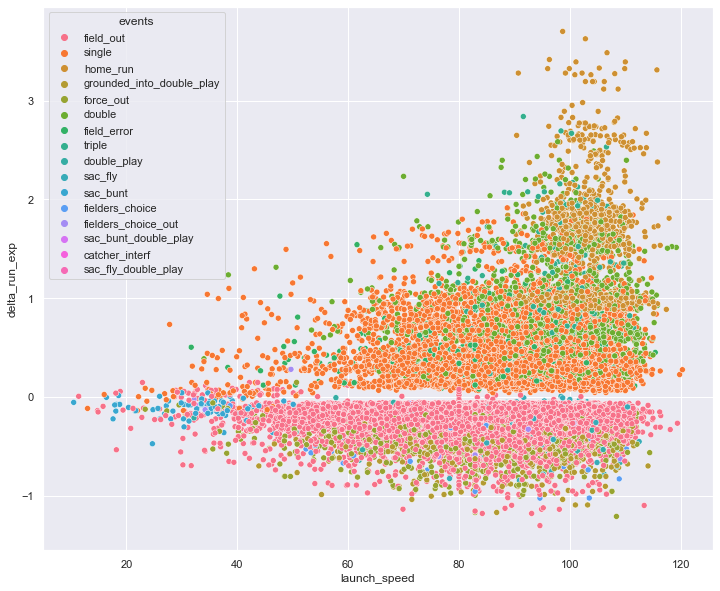

In [20]:

# launch speed vs delta run exp by events
# delete catcher interference, use in non bip dataset

sns.set(rc={'figure.figsize':(12, 10)})
sns.scatterplot(data=training, x="launch_speed", y="delta_run_exp", hue='events')

<AxesSubplot:xlabel='launch_angle', ylabel='delta_run_exp'>

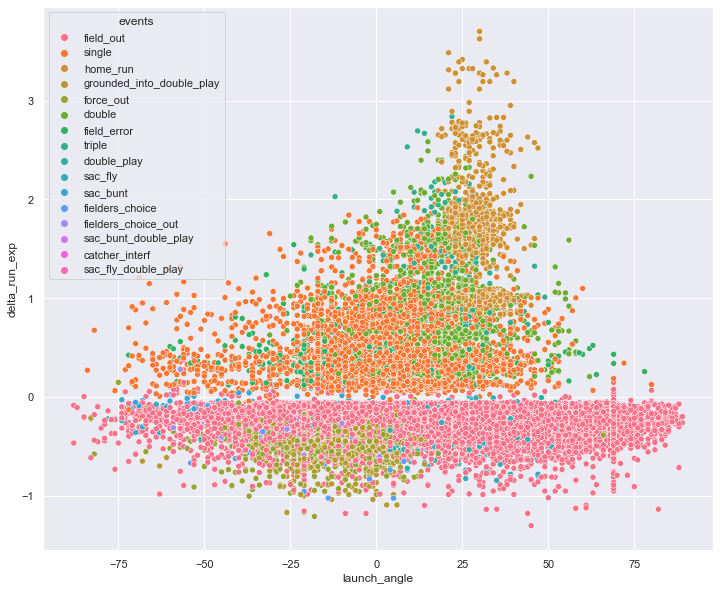

In [21]:
# launch angle vs change in run expectancy by events

sns.set(rc={'figure.figsize':(12, 10)})
sns.scatterplot(data=training, x="launch_angle", y="delta_run_exp", hue='events')

#### Non Ball in Play Outcomes

In [22]:
sql2 = '''
    SELECT "game_date","player_name", "pitcher", "pitcher_team", "batter", "description", "launch_speed", "launch_angle", "delta_run_exp", "cluster_name"
    FROM clustering
    WHERE "description"!='hit_into_play'
'''
print('Importing non ball in play dataset')
non_bip = pd.read_sql_query(sql2, engine)
print('Non BIP shape: ', non_bip.shape)

Importing non ball in play dataset
Non BIP shape:  (3131400, 10)


In [25]:
# e_delta_re for non ball in play will be the average of each instance of that event

# should description actually be events for the groupby?

non_bip['e_delta_re'] = non_bip.groupby('description')['delta_run_exp'].transform('mean')

## Ball in Play Outcomes

In [26]:
sql3 = '''
    SELECT "game_date", "player_name", "pitcher", "pitcher_team", "batter", "description", "launch_speed", "launch_angle", "delta_run_exp", "cluster_name"
    FROM clustering
    WHERE "description"='hit_into_play' AND "game_date" > '2020-12-31'
'''
print('Importing ball in play dataset')
bip = pd.read_sql_query(sql3, engine)
print('BIP Shape: ', bip.shape)

Importing ball in play dataset
BIP Shape:  (122892, 10)


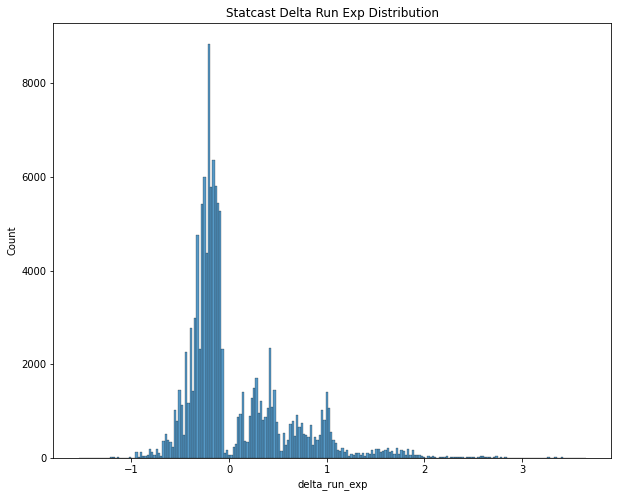

In [18]:
plt.figure(figsize=(10,8))
sns.histplot(data=bip, x="delta_run_exp")
plt.title('Statcast Delta Run Exp Distribution')
plt.show()

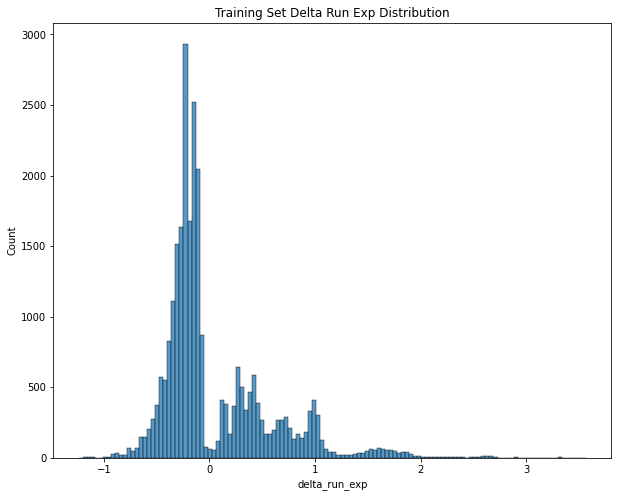

In [19]:
plt.figure(figsize=(10,8))
sns.histplot(data=training, x="delta_run_exp")
plt.title('Training Set Delta Run Exp Distribution')
plt.show()

In [35]:
def impute_zero(df, cols):
    df[cols] = df[cols].fillna(0)
    return df

training = impute_zero(training, ['launch_speed_angle', 'estimated_woba_using_speedangle', 'estimated_ba_using_speedangle',
                                  'launch_speed', 'launch_angle'])

In [36]:
training.isnull().sum()

game_date                          0
player_name                        0
pitcher                            0
events                             0
batter                             0
description                        0
launch_speed                       0
launch_angle                       0
launch_speed_angle                 0
estimated_woba_using_speedangle    0
estimated_ba_using_speedangle      0
delta_run_exp                      1
dtype: int64

In [37]:
training = pd.get_dummies(training, columns=['launch_speed_angle'])

In [38]:
training[['launch_speed', 'launch_angle', "launch_speed_angle_0.0",
                 "launch_speed_angle_1.0", "launch_speed_angle_2.0",
                 "launch_speed_angle_3.0", "launch_speed_angle_4.0",
                 "launch_speed_angle_5.0", "launch_speed_angle_6.0",
                 "estimated_woba_using_speedangle",
                 "estimated_ba_using_speedangle"]].describe()

,launch_speed,launch_angle,launch_speed_angle_0.0,launch_speed_angle_1.0,launch_speed_angle_2.0,launch_speed_angle_3.0,launch_speed_angle_4.0,launch_speed_angle_5.0,launch_speed_angle_6.0,estimated_woba_using_speedangle,estimated_ba_using_speedangle
count,33878.000000,33878.000000,33878.000000,33878.000000,33878.000000,33878.000000,33878.000000,33878.000000,33878.000000,33878.000000,33878.000000
mean,86.623030,11.794262,0.015674,0.041089,0.325580,0.248303,0.242753,0.057205,0.069396,0.363500,0.319618
std,17.851839,27.644931,0.124212,0.198498,0.468598,0.432035,0.428754,0.232238,0.254130,0.395317,0.295145
min,0.000000,-88.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,80.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071000,0.073000
50%,90.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.222000,0.220000
75%,98.600000,30.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.549000,0.533000
max,118.700000,89.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.032000,1.000000


In [39]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33878 entries, 321251 to 62908
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   game_date                        33878 non-null  object 
 1   player_name                      33878 non-null  object 
 2   pitcher                          33878 non-null  int64  
 3   events                           33878 non-null  object 
 4   batter                           33878 non-null  int64  
 5   description                      33878 non-null  object 
 6   launch_speed                     33878 non-null  float64
 7   launch_angle                     33878 non-null  float64
 8   estimated_woba_using_speedangle  33878 non-null  float64
 9   estimated_ba_using_speedangle    33878 non-null  float64
 10  delta_run_exp                    33877 non-null  float64
 11  launch_speed_angle_0.0           33878 non-null  uint8  
 12  launch_speed_

In [40]:
training[['launch_speed', 'launch_angle', "launch_speed_angle_0.0",
                 "launch_speed_angle_1.0", "launch_speed_angle_2.0",
                 "launch_speed_angle_3.0", "launch_speed_angle_4.0",
                 "launch_speed_angle_5.0", "launch_speed_angle_6.0",
                 "estimated_woba_using_speedangle",
                 "estimated_ba_using_speedangle"]].isnull().sum()

launch_speed                       0
launch_angle                       0
launch_speed_angle_0.0             0
launch_speed_angle_1.0             0
launch_speed_angle_2.0             0
launch_speed_angle_3.0             0
launch_speed_angle_4.0             0
launch_speed_angle_5.0             0
launch_speed_angle_6.0             0
estimated_woba_using_speedangle    0
estimated_ba_using_speedangle      0
dtype: int64

### MLFlow
- MlFlow will log metrics, the model and any artifacts associated with the run
- Change hyperparameter tuning to hyperopt, log parameters and best model

In [16]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

with mlflow.start_run():

  # split the data
  X, y = training[['launch_speed', 'launch_angle', "launch_speed_angle_0.0",
                 "launch_speed_angle_1.0", "launch_speed_angle_2.0",
                 "launch_speed_angle_3.0", "launch_speed_angle_4.0",
                 "launch_speed_angle_5.0", "launch_speed_angle_6.0",
                 "estimated_woba_using_speedangle",
                 "estimated_ba_using_speedangle"]], training['delta_run_exp']

  # create train and test sets
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, random_state=13, test_size=0.3)

  rf_reg = Pipeline(steps=[('scaler', StandardScaler()),
                        ('regressor', RandomForestRegressor(n_jobs=-1, n_estimators=500, max_depth=5, max_features='auto'))])

  # param_dist = { 
  #         'regressor__n_estimators': [100, 200, 500],
  #         'regressor__max_depth':[None, 5, 8],
  #         'regressor__max_features': ['auto', 'sqrt', 'log2']
  # }

  # search = GridSearchCV(rf_reg, 
  # param_dist, n_jobs=-1, scoring='neg_root_mean_squared_error')
  # search.fit(X_train, y_train)
  # search.best_params_

  y_pred = rf_reg.predict(X_test)

  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  print('rmse: ', rmse)

  r2 = r2_score(y_test, y_pred)
  print('r2: ', r2)

  mae = mean_absolute_error(y_test, y_pred)
  print('mae: ', mae)

  mlflow.log_metric("rmse", rmse)
  mlflow.log_metric("r2", r2)
  mlflow.log_metric("mae", mae)
  mlflow.sklearn.log_model(rf_reg, "model")

rmse:  0.4821982266826273
r2:  0.20086273620055817
mae:  0.32941223065913855


### Manual Run - no mlflow logging

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# split the data
X, y = training[['launch_speed', 'launch_angle', "launch_speed_angle_0.0",
                 "launch_speed_angle_1.0", "launch_speed_angle_2.0",
                 "launch_speed_angle_3.0", "launch_speed_angle_4.0",
                 "launch_speed_angle_5.0", "launch_speed_angle_6.0",
                 "estimated_woba_using_speedangle",
                 "estimated_ba_using_speedangle"]], training['delta_run_exp']

# create train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=13, test_size=0.3)
    
print(X_train.shape)
print(X_test.shape)

# bring pipelines together for modeling
rf_reg = Pipeline(steps=[('scaler', StandardScaler()),
                        ('regressor', RandomForestRegressor(n_jobs=-1))])
print('rf_reg')
# set hyperparameter grid for tuning

param_dist = { 
          'regressor__n_estimators': [100, 200, 500],
          'regressor__max_depth':[None, 5, 8],
          'regressor__max_features': ['auto', 'sqrt', 'log2']
}

print('fitting model')

# rf_reg.fit(X_train, y_train)

# do search
search = GridSearchCV(rf_reg, 
param_dist, n_jobs=-1, scoring='neg_root_mean_squared_error')
search.fit(X_train, y_train)
search.best_params_

(23947, 11)
(10264, 11)
rf_reg
fitting model


{'regressor__max_depth': 5,
 'regressor__max_features': 'auto',
 'regressor__n_estimators': 200}

### Model Performance

In [16]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_pred = search.best_estimator_.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('rmse: ', rmse)

r2 = r2_score(y_test, y_pred)
print('r2: ', r2)

mae = mean_absolute_error(y_test, y_pred)
print('mae: ', mae)

rmse:  0.42955922589242185
r2:  0.366360075085547
mae:  0.29338883134930555


[Text(418.5, 498.3, 'estimated_woba_using_speedangle <= 0.65\nmse = 0.283\nsamples = 15176\nvalue = 0.058'),
 Text(209.25, 407.70000000000005, 'estimated_woba_using_speedangle <= 0.287\nmse = 0.167\nsamples = 12228\nvalue = -0.071'),
 Text(104.625, 317.1, 'estimated_woba_using_speedangle <= 0.119\nmse = 0.11\nsamples = 8415\nvalue = -0.155'),
 Text(52.3125, 226.5, 'launch_speed <= 40.05\nmse = 0.065\nsamples = 5316\nvalue = -0.206'),
 Text(26.15625, 135.89999999999998, 'launch_speed <= 39.35\nmse = 0.19\nsamples = 235\nvalue = 0.041'),
 Text(13.078125, 45.299999999999955, 'mse = 0.191\nsamples = 234\nvalue = 0.039'),
 Text(39.234375, 45.299999999999955, 'mse = -0.0\nsamples = 1\nvalue = 0.32'),
 Text(78.46875, 135.89999999999998, 'estimated_woba_using_speedangle <= 0.078\nmse = 0.056\nsamples = 5081\nvalue = -0.217'),
 Text(65.390625, 45.299999999999955, 'mse = 0.042\nsamples = 3770\nvalue = -0.234'),
 Text(91.546875, 45.299999999999955, 'mse = 0.094\nsamples = 1311\nvalue = -0.168'),


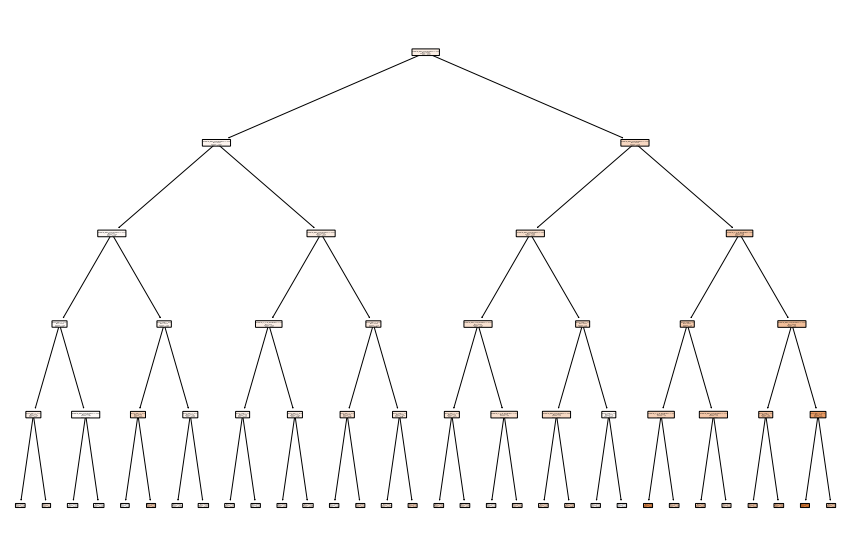

In [18]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 10))
plot_tree(rf.estimators_[0], 
          feature_names=X.columns, 
          filled=True, impurity=True, 
          rounded=True)

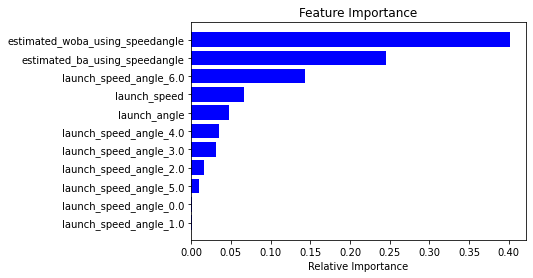

In [38]:
features = X_train.columns.to_list()
importances = search.best_estimator_._final_estimator.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

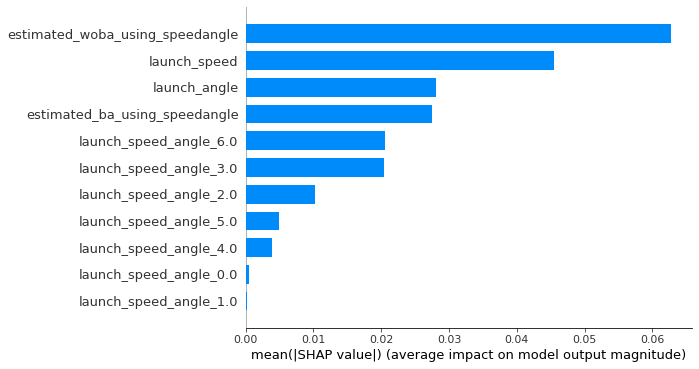

In [39]:
import shap
shap_values = shap.TreeExplainer(search.best_estimator_._final_estimator).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

### Scoring
- Code for serving up scores to the app

In [23]:
scoring = bip

In [25]:
scoring.shape

(122866, 11)

In [24]:
scoring['e_delta_re'] = search.best_estimator_.predict(scoring[['launch_speed','launch_angle']])

In [57]:
scoring['game_date'].max()

'2021-11-02 00:00:00'

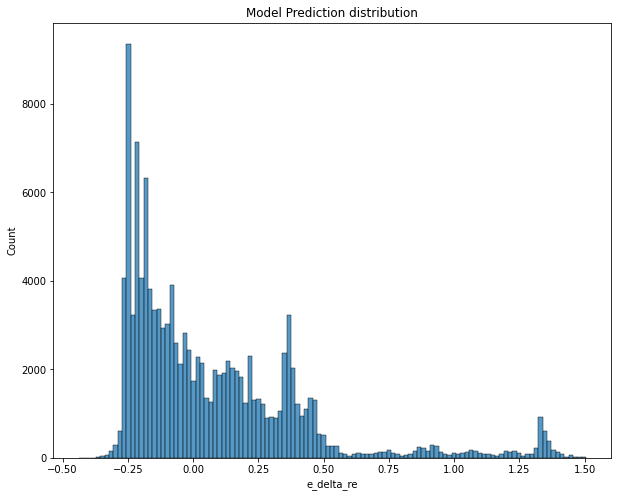

In [27]:
plt.figure(figsize=(10,8))
sns.histplot(data=scoring, x="e_delta_re")
plt.title('Model Prediction distribution')
plt.show()

In [28]:
frames = [scoring, non_bip]

df_concat = pd.concat(frames)

In [29]:
# get average scores per batter per cluster faced

df_concat['clust_e_delta_re_mean'] = df_concat.groupby(['batter', 'cluster_name'])['e_delta_re'].transform('mean')

In [30]:
# obtain pitcher cluster distributions

df_concat_2 = df_concat.groupby(['pitcher', 'cluster_name']).size().unstack(fill_value=0).reset_index()

In [31]:
cluster_cols = df_concat_2.iloc[:, 1:]

In [32]:
cols = cluster_cols.columns

df_concat_2[cols] = df_concat_2[cols].div(df_concat_2[cols].sum(axis=1), axis=0)

In [33]:
df_concat_2

cluster_name,pitcher,lhp_cukc_0,lhp_cukc_1,lhp_cukc_2,lhp_cukc_3,lhp_ff_0,lhp_ff_1,lhp_ff_2,lhp_ff_3,lhp_mf_0,...,rhp_mf_3,rhp_mf_4,rhp_off_0,rhp_off_1,rhp_off_2,rhp_off_3,rhp_slct_0,rhp_slct_1,rhp_slct_2,rhp_slct_3
0,112526,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.007634,0.175573,0.012723,0.071247,0.002545,0.000000,0.027990,0.005089,0.015267,0.025445
1,150274,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000
2,276351,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.005747,0.022989,0.000000,0.000000,0.005747,0.000000,0.189655,0.074713,0.022989,0.000000
3,276520,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.030303,0.030303,0.030303,0.227273,0.075758,0.075758
4,276542,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.014085,0.049296,0.035211,0.105634,0.000000,0.197183,0.007042,0.000000,0.063380,0.049296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,681867,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.100000,0.100000,0.000000,0.000000
1673,681911,0.0,0.0,0.0,0.0,0.303665,0.198953,0.162304,0.057592,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1674,683232,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1675,685493,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.022222,0.088889,0.000000,0.333333,0.044444,0.022222,0.022222,0.000000


In [34]:
# retrieve distribution percentages for each pitcher

cluster_sum = df_concat_2.melt(id_vars=["pitcher"], var_name="cluster_name_pitcher", value_name="value")

cluster_sum = cluster_sum[cluster_sum.value != 0]

In [35]:
df_concat

,game_date,player_name,pitcher,pitcher_team,batter,description,launch_speed,launch_angle,delta_run_exp,cluster_name,e_delta_re,clust_e_delta_re_mean
0,2021-10-30 00:00:00,"Wright, Kyle",657140,ATL,503556,hit_into_play,92.9,44.0,-0.411,rhp_mf_3,-0.240690,0.040123
1,2021-10-30 00:00:00,"Wright, Kyle",657140,ATL,663656,hit_into_play,106.4,9.0,0.134,rhp_mf_2,0.450774,0.060820
2,2021-10-30 00:00:00,"Wright, Kyle",657140,ATL,621043,hit_into_play,66.4,-18.0,-0.189,rhp_mf_2,-0.215971,0.064803
3,2021-10-30 00:00:00,"Wright, Kyle",657140,ATL,514888,hit_into_play,105.2,30.0,1.027,rhp_mf_3,1.368161,-0.023741
4,2021-10-30 00:00:00,"Wright, Kyle",657140,ATL,455117,hit_into_play,77.0,-21.0,-0.216,rhp_mf_1,-0.222099,-0.033769
...,...,...,...,...,...,...,...,...,...,...,...,...
305543,2021-04-01 00:00:00,"Detwiler, Ross",446321,MIA,650490,swinging_strike,0.0,0.0,-0.114,lhp_off_1,-0.223017,0.030058
305544,2021-04-01 00:00:00,"Boyd, Matthew",571510,DET,614177,ball,0.0,0.0,0.312,lhp_off_1,0.213763,0.037109
305545,2021-04-01 00:00:00,"Ryu, Hyun Jin",547943,TOR,457803,ball,0.0,0.0,0.092,lhp_off_0,0.213763,-0.149639
305546,2021-04-01 00:00:00,"Ryu, Hyun Jin",547943,TOR,570482,swinging_strike,0.0,0.0,-0.210,lhp_off_3,-0.223017,-0.020255


In [36]:
# merge df's back together

df2 = df_concat[['batter', 'pitcher', 'pitcher_team', 'game_date', 'cluster_name', 'clust_e_delta_re_mean']].merge(cluster_sum, left_on=['pitcher', 'cluster_name'], right_on=['pitcher', 'cluster_name_pitcher'])


In [37]:
# calculate scores

df2['score'] = df2['value'] * df2['clust_e_delta_re_mean']

In [38]:
# calculate matchup scores for batter vs pitcher

df2['matchup_score'] = df2.groupby(['batter', 'pitcher'])['score'].transform('sum')

In [39]:
sql1 = '''
    SELECT *
    FROM player_lookup
'''
player_lookup = pd.read_sql_query(sql1, engine)

sql_pitching = '''
    SELECT distinct("IDfg"), max("G") as G, max("GS") as GS
    FROM pitching
    GROUP BY "IDfg", "Team"
'''

pitching = pd.read_sql_query(sql_pitching, engine)

sql_hitting = '''
    SELECT distinct("IDfg")
    FROM hitting  
'''

hitting = pd.read_sql_query(sql_hitting, engine)

In [40]:
player_lookup

,index,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,0,Aardsma,David,430911,aardd001,aardsda01,1902,2004.0,2015.0
1,1,Aaron,Hank,110001,aaroh101,aaronha01,1000001,1954.0,1976.0
2,2,Aaron,Tommie,110002,aarot101,aaronto01,1000002,1962.0,1971.0
3,3,Aase,Don,110003,aased001,aasedo01,1000003,1977.0,1990.0
4,4,Abad,Andy,407577,abada001,abadan01,506,2001.0,2006.0
...,...,...,...,...,...,...,...,...,...
24083,24083,Zupo,Frank,124788,zupof101,zupofr01,1014464,1957.0,1961.0
24084,24084,Zuvella,Paul,124789,zuvep001,zuvelpa01,1014465,1982.0,1991.0
24085,24085,Zuverink,George,124790,zuveg101,zuverge01,1014466,1951.0,1959.0
24086,24086,Zwilling,Dutch,124791,zwild101,zwilldu01,1014467,1910.0,1916.0


In [42]:
df3 = player_id(df=df2, player_lookup=player_lookup, pitching=pitching, hitting=hitting)

(352502, 26)

In [59]:
print(df3['game_date'].max())
print(df3['game_date'].min())

2021-11-02 00:00:00
2016-04-03 00:00:00


In [54]:
# create pitcher dataframe for 2021 pitchers only

pitcher_df = df3[['pitcher_name', 'pitcher_team', 'game_date']].sort_values('game_date').groupby('pitcher_name').tail(1)
pitcher_df_2021 = pitcher_df.loc[pitcher_df['game_date']>'2021-01-01']

In [58]:
pitcher_df['game_date'].max()

'2021-11-02 00:00:00'

In [55]:
print(pitcher_df.shape)
print(pitcher_df_2021.shape)

(881, 3)
(881, 3)


In [53]:
print(df3['game_date'].min())
print(df3['game_date'].max())

2016-04-03 00:00:00
2021-11-02 00:00:00


In [50]:
# create final dataset

df3_2021 = df3.loc[df3['game_date']>'2021-03-01']
df3_2021_reco = df3_2021[['batter_name', 'pitcher_name', 'pitcher_team', 'matchup_score', 'isStarter']].merge(pitcher_df, on='pitcher_name', how='inner').drop(columns=['pitcher_team_x', 'game_date']).rename(columns = {'pitcher_team_y':'pitcher_team'}).drop_duplicates()
print(df3_2021.shape)
print(df3_2021_reco.shape)

(183009, 26)
(84446, 5)


In [30]:
df3_2021_reco.to_sql('bp_reco_df', engine, if_exists='replace', 
               chunksize= 100, method='multi')

In [62]:
def bp_reco(batter, pitcher_tm, df):
    df_reco = df.loc[df['batter_name']==batter]
    df_reco_team = df_reco.loc[df_reco['pitcher_team']==pitcher_tm]

    return df_reco_team.sort_values(by=['matchup_score'])

yoyo = bp_reco('Anderson, Tim', 'CLE', df3_2021_reco)

yoyo.loc[yoyo['isStarter']==False]

,batter_name,pitcher_name,matchup_score,isStarter,pitcher_team
99903,"Anderson, Tim","Shaw, Bryan",-0.157581,False,CLE
128113,"Anderson, Tim","Clase, Emmanuel",-0.132685,False,CLE
120770,"Anderson, Tim","Stephan, Trevor",-0.045530,False,CLE
51838,"Anderson, Tim","Mejia, J. C.",-0.044800,False,CLE
67562,"Anderson, Tim","Sandlin, Nick",-0.041274,False,CLE
92473,"Anderson, Tim","Karinchak, James",-0.015408,False,CLE
46058,"Anderson, Tim","Quantrill, Cal",-0.009052,False,CLE
147317,"Anderson, Tim","Hentges, Sam",-0.007070,False,CLE
117429,"Anderson, Tim","Wittgren, Nick",-0.004360,False,CLE
37535,"Anderson, Tim","Garza, Justin",-0.003117,False,CLE
